## Image Reconstruction

This notebook performs reconstruction of fNIRS data.<br><br>   

 You can download the notebook from the [NeuroDOT_Py GitHub](https://github.com/WUSTL-ORL/NeuroDOT_py) 

In [1]:
# General imports
import sys
import math
import os
import shutil
import json

import sys
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.io import savemat


import neuro_dot as ndot

In [2]:
# To get started, edit this cell for folder paths; EDIT AT THE BEGINNING ONLY
saveImages = 'yes' # Options are yes/no to save output figures (must be lowercase 'yes' or 'no')
saveImagePath ="./Output" # Path to folder to save output, figures will be saved to subdirectory called 'Output_Images'
saveNoteBookPath = "./Output" # Path to folder to save output, Jupyter Notebook will be saved to subdirectory called 'Output_Notebook'

In [3]:
# RUN THIS CELL ONLY ONCE IF YOU CHOOSE TO RE RUN THE CELL ABOVE FIRST
if saveImages == 'yes':
    saveImagePath = saveImagePath + '/Output_Images/'
    if not os.path.exists(saveImagePath): 
        os.makedirs(saveImagePath)
    # The code below is only relevant for use with XNAT container
    saveNoteBookPath = saveNoteBookPath + '/Output_Notebook/'
    if not os.path.exists(saveNoteBookPath):
        os.makedirs(saveNoteBookPath)
else:
    print('SAVED IMAGES IS SET TO NO. NO IMAGES WILL BE SAVED.')

In [4]:
# TO MAKE CHANGES TO FIGURES, EDIT ONLY THIS CELL
# participant_data = "/input/subjectdata.mat"  # Path to data; an example data set has been provided here
## Load data
participant_data = 'NeuroDOT_Data_Sample_CCW1.mat' # Name of your data file, or one of the NeuroDOT data samples in the 'Data' folder
data_path = os.path.abspath(os.path.join(sys.path[0],"../..", 'Data', participant_data))
data = ndot.loadmat(data_path)['data']     
__info = ndot.loadmat(data_path)['info']             
flags = ndot.loadmat(data_path)['flags']
A = None        
E = None
MNI = None
params = {'bthresh':0.01,'det':1, 'highpass':1, 'lowpass1':1, 'ssr':1, 'lowpass2':1, 'DoGVTD':1, 'resample': 1, 'omega_hp': 0.02, 'omega_lp1': 1, 'omega_lp2': 0.5,'freqout': 1, 'rstol': 1e-5 ,'DQC_ONLY': 0, 'omega_resample': 1} #flags. in dot_processing preprocessing section add to params list

In [5]:
os.path.join(os.path.dirname(sys.path[0]),'Support_Files/Spectroscopy/E.mat')

'e:\\Emma\\neuroDOT\\NeuroDOT_py\\Support_Files/Spectroscopy/E.mat'

In [6]:
# Set parameters for A and block length for quick processing examples
if 'CCW1' in participant_data or 'CCW2' in participant_data or 'CW1' in participant_data or 'OUT' in participant_data:
    A_fn=os.path.join(os.path.dirname(sys.path[0]),'Support Files', 'A Matrices', 'A_AdultV24x28.mat') #  Sensitivity Matrix (path to A matrix on your machine! this file is too large to go in the GitHub repo being worked out of)
    params['dt']=36                     # Block length
    params['tp']=16                     # Example (block averaged) time point
if 'IN1' in participant_data:
    A_fn=os.path.join(os.path.dirname(sys.path[0]),'Support Files', 'A Matrices', 'A_AdultV24x28.mat') # Sensitivity Matrix
    params['dt']=36                     # Block length
    params['tp']=32                     # Example (block averaged) time point

if  'HW1'in participant_data or'HW2' in participant_data or'RW1' in participant_data or'GV1'in participant_data or'HW3_Noisy' in participant_data:
    A_fn=os.path.join(os.path.dirname(sys.path[0]),'Support Files', 'A Matrices', 'A_Adult_96x92.mat')   # Sensitivity Matrix
    params['dt']=30                     # Block length
    params['tp']=16                     # Example (block averaged) time point
    print("IF THIS IS THE FIRST TIME YOU ARE USING THIS, THIS MATRIX IS NOT IN YOUR FOLDER TOO LARGE TO UPLOAD PLEASE EMAIL ESPEH@WUSTL.EDU TO GET IT")

2381 25702


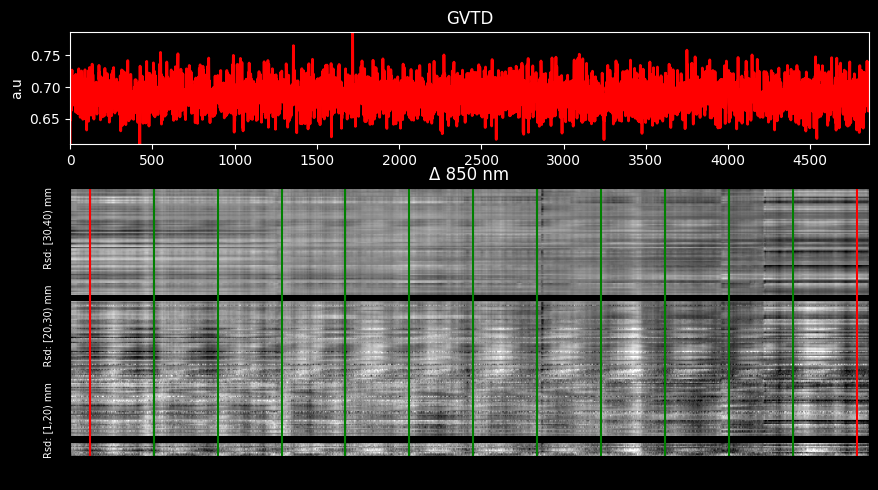

In [7]:
## PRE-PREOCESSING PIPELINE

lmdata = ndot.logmean(data)[0]                                    # Logmean Light Levels
info = ndot.FindGoodMeas(lmdata, __info, 0.075)                    # Detect Noisy Channels
gvtd = ndot.CalcGVTD(lmdata)
info['GVTD'] = gvtd

ndot.nlrGrayPlots_220324(lmdata,info)  # Gray Plot with synch points

lmdata = ndot.detrend_tts(lmdata)      
hpdata = ndot.highpass(lmdata, .02, info['system']['framerate'])  # High Pass Filter (0.02 Hz)
lp1data = ndot.lowpass(hpdata, 1, info['system']['framerate'])    # Low Pass Filter 1 (1.0 Hz)
hem = ndot.gethem(lp1data, info)                                  # Superficial Signal Regression
lp1data, _ = ndot.regcorr(lp1data, info, hem)
lp2data = ndot.lowpass(lp1data, 0.2, info['system']['framerate']) # Low Pass Filter 2 (0.5 Hz)
resample_data, info = ndot.resample_tts(lp2data, info, 1, 1e-5)   # 1 Hz Resampling (1 Hz)


(0.001, 1)

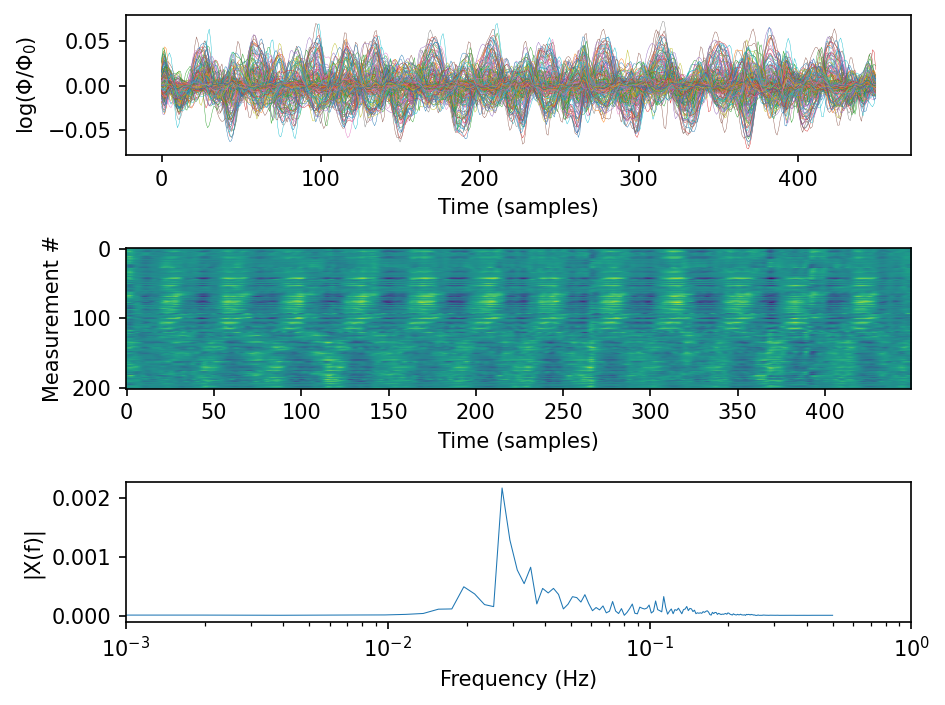

In [8]:
## View pre-processed data
keep = np.logical_and(np.logical_and(np.where(info['pairs']['WL'] == 2,1,0), np.where(info['pairs']['r2d'] < 40,1,0)), info['MEAS']['GI']) # measurements to include

fig = plt.figure(dpi = 150, tight_layout = True)
gs = gridspec.GridSpec(3,1)
ax1 =  plt.subplot(gs[0,0])
ax2 =  plt.subplot(gs[1,0])
ax3 =  plt.subplot(gs[2,0])

ax1.plot(np.transpose(resample_data[keep,:]), linewidth = 0.2) # plot signals 
ax1.set_xlabel('Time (samples)')
ax1.set_ylabel('log(\u03A6/$\u03A6_{0}$)')  

im2 = ax2.imshow(resample_data[keep,:], aspect = 'auto')
ax2.set_xlabel('Time (samples)')
ax2.set_ylabel('Measurement #') 
xplot = np.transpose(np.reshape(np.mean(np.transpose(resample_data[keep,:]),1), (len(np.mean(np.transpose(resample_data[keep,:]),1)),1)))

ftdomain, ftmag,_,_ = ndot.fft_tts(xplot,info['system']['framerate']) # Generate average spectrum
ftmag = np.reshape(ftmag, (len(ftdomain)))
ax3.semilogx(ftdomain,ftmag, linewidth = 0.5) # plot vs. log frequency
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('|X(f)|') 
ax3.set_xlim([1e-3, 1])


Text(0, 0.5, 'Measurement #')

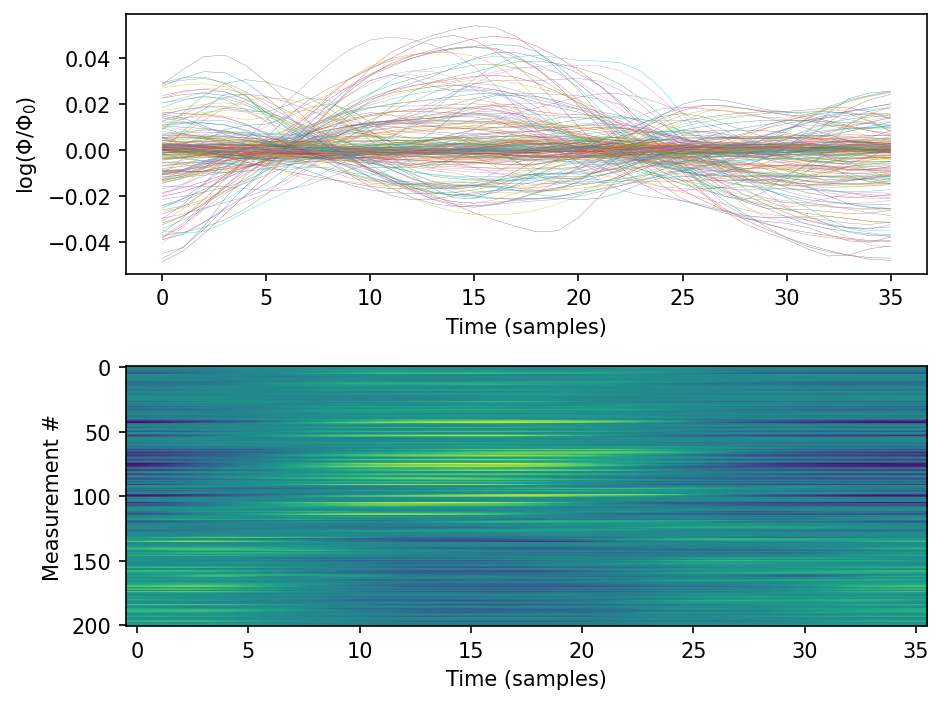

In [9]:
## Block Averaging the measurement data and view
badata = ndot.BlockAverage(resample_data, info['paradigm']['synchpts'][info['paradigm']['Pulse_2']], params['dt'])[0]

mean_badata = np.ndarray.mean(badata, axis = 1,dtype = np.float64)
badata = badata - mean_badata[:,None]

keep = np.logical_and(np.logical_and(np.where(info['pairs']['WL'] == 2,1,0), np.where(info['pairs']['r2d'] < 40,1,0)), info['MEAS']['GI']) 

fig = plt.figure(dpi = 150, tight_layout = True)
gs = gridspec.GridSpec(2,1)
ax1 =  plt.subplot(gs[0,0])
ax2 =  plt.subplot(gs[1,0])

ax1.plot(np.transpose(badata[keep,:]), linewidth = 0.15) # plot signals 
ax1.set_xlabel('Time (samples)')
ax1.set_ylabel('log(\u03A6/$\u03A6_{0}$)')  

im2 = ax2.imshow(badata[keep,:], aspect = 'auto')
ax2.set_xlabel('Time (samples)')
ax2.set_ylabel('Measurement #') 

In [10]:
## RECONSTRUCTION PIPELINE
A = None
if A is None:
    A = {}
    if  'HW1'in participant_data or'HW2' in participant_data or'RW1' in participant_data or'GV1'in participant_data or'HW3_Noisy' in participant_data:
        A['A'] = ndot.loadmat7p3(A_fn)['A']
        A['infoA'] = ndot.loadmat7p3(A_fn)['info']
        for key in A['infoA']['tissue']['dim']:
            if type(A['infoA']['tissue']['dim'][key]) == int or type(A['infoA']['tissue']['dim'][key]) == float :
                if np.size(A['infoA']['tissue']['dim'][key]) ==1:
                    A['infoA']['tissue']['dim'][key] = int(A['infoA']['tissue']['dim'][key])
    else:
        A['A'] = ndot.loadmat(A_fn)['A']
        A['infoA'] = ndot.loadmat(A_fn)['info']

    if len(A['A'].shape)>2:  # A data structure [wl X meas X vox]-->[meas X vox] # refer to matlab code for this
        Nwl = A['A'].shape[0]
        Nmeas = A['A'].shape[1]
        Nvox = A['A'].shape[2]
        A['A']=np.reshape(np.transpose(A['A'],(1,0,2)),Nwl*Nmeas,Nvox) # Changed permute to transpose 

Nvox= A['A'].shape[1]
Nt=resample_data.shape[1]
cortex_mu_a=np.zeros((Nvox,Nt,2))

for j in range(1,3): 
    keep = np.logical_and(np.logical_and(np.where(info['pairs']['WL'] == j,1,0), np.where(info['pairs']['r2d'] <= 40,1,0)), info['MEAS']['GI']) 
    print('> Inverting A')                
    iA = ndot.Tikhonov_invert_Amat(A['A'][keep, :], 0.01, 0.1)                 # Invert A-Matrix
    print('> Smoothing iA')
    iA = ndot.smooth_Amat(iA, A['infoA']['tissue']['dim'], 2)                  # Smooth Inverted A-Matrix      
    cortex_mu_a[:, :, j-1] = ndot.reconstruct_img(resample_data[keep, :], iA)  # Reconstruct Image Volume 

#  Spectroscopy
Emat = os.path.join(os.path.dirname(sys.path[0]),'Support Files', 'Spectroscopy', 'E.mat')
if E is None:    
    E = ndot.loadmat(Emat)['E']
cortex_Hb = ndot.spectroscopy_img(cortex_mu_a, E) 
cortex_HbO = cortex_Hb[:, :, 0]
cortex_HbR = cortex_Hb[:, :, 1]
cortex_HbT = cortex_HbO + cortex_HbR


> Inverting A
> Smoothing iA
> Inverting A
> Smoothing iA


In [11]:
## Select Volumetric visualizations of block averaged data
MNI_file = os.path.join(os.path.dirname(sys.path[0]),'Support Files', 'Atlases', 'Segmented_MNI152nl_on_MNI111_py')
if MNI is None:   
    MNI=ndot.loadmat(MNI_file)['vol'] # load MNI atlas (same data set as in A matrix dim)
    infoB=ndot.loadmat(MNI_file)['h']
MNI_dim = ndot.affine3d_img(MNI,infoB,A['infoA']['tissue']['dim'],affine =np.eye(4),interp_type ='nearest') # transform to DOT volume space  


In [ ]:
# Flat Field Reconstruction
a=np.squeeze(A['A'][keep,:])

ffr = ndot.makeFlatFieldRecon(a, iA)
fooV = ndot.GoodVox2vol(ffr, A['infoA']['tissue']['dim'])
fooV = fooV/np.amax(fooV)

Params_recon = {}
Params_recon['Th'] = {}
Params_recon['Scale']=1
Params_recon['Th']['P']=1e-2
Params_recon['Th']['N']=-Params_recon['Th']['P']
Params_recon['Cmap']='jet' 
Params_recon['slices'] = [34,5,12]

ndot.PlotSlices(MNI_dim, infoB, params = Params_recon, overlay = fooV);
plt.close() 

In [ ]:

badata_HbO = ndot.BlockAverage(cortex_HbO, info['paradigm']['synchpts'][info['paradigm']['Pulse_2']-1], params['dt'])[0]

badata_HbO= badata_HbO - badata_HbO[:,0, None]

badata_HbOvol = ndot.GoodVox2vol(badata_HbO,A['infoA']['tissue']['dim'])

Params_recon = {}
Params_recon['Th'] = {}
Params_recon['Scale']=0.8*np.amax(abs(badata_HbOvol))
Params_recon['Th']['P']= 0.2*Params_recon['Scale']
Params_recon['Th']['N']=-0.2*Params_recon['Scale']
Params_recon['Cmap']='jet' 

ndot.PlotSlicesTimeTrace(MNI_dim,A['infoA']['tissue']['dim'],Params_recon,badata_HbOvol,info)
plt.close()

In [ ]:
## Visualize block-averaged absorption and HbR, HbT data 
# use either of the next two lines to select mu_a (wavelength of 1 or 2 in the third
# dimension) or HbO, HbR, or HbT (second line)
# badata_HbO = anlys.BlockAverage(cortex_mu_a[:,:,1], info['paradigm']['synchpts'][info['paradigm']['Pulse_2]], info['dt'])
badata_HbT = ndot.BlockAverage(cortex_HbT, info['paradigm']['synchpts'][info['paradigm']['Pulse_2']-1], params['dt'])[0]
first_col = badata_HbT[:,0]
badata_HbT= badata_HbT - first_col[:,None]
badata_HbTvol = ndot.GoodVox2vol(badata_HbT,A['infoA']['tissue']['dim'])

Params_recon = {}
Params_recon['Th'] = {}
Params_recon['Scale']=0.8*np.amax(abs(badata_HbTvol))
Params_recon['Th']['P']=0.2*Params_recon['Scale']
Params_recon['Th']['N']=-Params_recon['Th']['P']
Params_recon['Cmap']='jet'
ndot.PlotSlicesTimeTrace(MNI_dim,A['infoA']['tissue']['dim'],Params_recon,badata_HbOvol,info)
plt.close()
